## Лабораторная работа № 3
#### по курсу "Искусственный интеллект"
##### Выполнила: Вельтман Л.Я.
#### Группа: М8О-307Б-17

### Задание:
Генерация текстов/последовательностей с помощью рекуррентных нейронных сетей.

В качестве последовательностей: 

Вариант 1. Проза на русском языке, элемент последовательности - один символ. Источник данных - тексты на http://lib.ru

- Код оформить в виде Jupyter-ноутбука с пояснениями по ходу программы
- Для каждого задания необходимо исследовать несколько различных нейросетевых архитектур:
    - Обычная полносвязная RNN
    - Однослойная LSTM
    - Двухслойная LSTM
    - Однослойный GRU
- Результаты оформить в виде отчета Report.md

Импортируем необходимые библиотеки.

In [252]:
from __future__ import print_function
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
import keras.backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Flatten
from keras.layers import SimpleRNN, Reshape
from keras.layers import GRU, Embedding
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys
import io
import os
import string

Скачаем текст с http://lib.ru. Сохраним в директорию на ПК.

In [226]:
path = '/Users/linuxoid/Desktop/VUZICH/AI/lab3/parusa.txt'

Считываем текст для дальнейшей работы с ним.

In [227]:
with open(path, 'r') as f:
    text = f.read().lower()
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 140864 characters


Посмотрим на первые 250 символов текста в качестве дополнительной проверки и визуализации, что все считано верно.

In [228]:
print(text[:250])

     феерия




     нине николаевне грин подносит и посвящает
     автор пбг, 23 ноября 1922 г.

i предсказание



     лонгрен, матрос "ориона", крепкого  трехсоттонного брига, на котором он
прослужил десять  лет и к  которому  был привязан  сильне


Создадим словарь уникальных символов.

Получаем набор всех символов в тексте и составляем 2 словаря:
char_indices содержит символы и соответствующий им индекс
indices_char позволит по индексу получить символ

In [229]:
chars = sorted(list(set(text)))
print('total chars:', chars)
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

total chars: ['\n', ' ', '!', '"', '(', ')', ',', '-', '.', '1', '2', '3', '7', '9', ':', ';', '?', 'i', 'v', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'и', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'щ', 'ъ', 'ы', 'ь', 'э', 'ю', 'я']
total chars: 51


Вспомогательная функция, выдающая случайный индекс символа из наиболее вероятных.
temperature отвечает за вариативность выдаваемых индексов: более низкое значение будет выдавать более вероятный символ с меньшей вариативностью, и наоборот.
На вход функции подаются вероятности, предсказанные сетью, на выходе выдается индекс символа.

In [230]:
def sample(preds, temperature = 1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

Разрезаем текст на куски по maxlen символов с шагом step.

In [231]:
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

nb sequences: 46942


Преобразуем полученные последовательности символов в последовательности векторов, в которых каждому символу будет соотвествовать вектор [x1, x2, ..., xK, ... xN], где xK = 1, если K равно индексу данного символа, N = количество в нашем наборе chars, а все остальные значения равны нулю.

In [232]:
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Задаем гиперпараметры:
* `batch_size`: размер мини-батча, чем он меньше, тем менее усредненной будет ошибка, соответственно, будет выше точность и меньше вероятность скатиться в локальный минимум;
* `gen_length`: длина генерируемого текста в символах;
* `options`: массив опций для обучения; в нем хранятся наборы параметров для определенной архитектуры;
* `size`: количество узлов в слое;
* `epochs`: количество эпох (итераций) обучения;
* `type_of_network`: используемая нейросетевая архитектура;


In [233]:
batch_size = 256

# Длина словаря символов
vocab_size = len(chars)

gen_length = 1500

options = [

    {
        'size': 128,
        'epochs': 120,
        'type_of_network': '1RNN'
    },
    
    {
        'size': 128,
        'epochs': 120,
        'type_of_network': '1LSTM'
    },
    
    {
        'size': 256,
        'epochs': 30,
        'type_of_network': '2LSTM'
    }, 
    
    {
        'size': 256,
        'epochs': 25,
        'type_of_network': '1GRU'
    }
]

## Обучение
Для каждого набора параметров строим модель, обучаем ее за `epochs` итераций.
Первой моделью будет обычная полносвязная RNN нейросеть.

Обнуляем сессию.

In [234]:
K.clear_session()
option = options[0]

Функция для построения необходимой модели в зависимости от нужного типа.

- Архитектура сети RNN в виде последовательности слоёв. Определяем один скрытый слой LSTM с option['size'] = 256 единицами памяти. Для регуляции сети будем использовать слой Dropout с вероятностью 20, как правило, это делает узлы более устойчивыми к входам. Выходной уровень - это полносвязный (Dense) уровень, использующий функцию активации softmax для вывода прогнозирования вероятности для каждого из 51 символов в диапазоне от 0 до 1.

- Архитектуру однослойной LSTM в виде последовательности слоёв. Определяем один скрытый слой LSTM с option['size'] = 128 единицами памяти. Для регуляции сети будем использовать слой Dropout с вероятностью 20, как правило, это делает узлы более устойчивыми к входам. Выходной уровень - это полносвязный (Dense) уровень, использующий функцию активации softmax для вывода прогнозирования вероятности для каждого из 51 символов в диапазоне от 0 до 1.

- Архитектуру двухслойной LSTM сети в виде последовательности слоёв. Определим количество узлов для слоя LSTM, равное 256, и добавим еще второй слой LSTM. Теперь мы имеем уже два слоя LSTM, регулязацию которых выполняем при помощи техники dropout. Добавляем полносвязный слой с функцией активации - непрерывная функция softmax с 51 выходами, равное количеству уникальных символов в нашем тексте.

- Архитектура ондослойной GRU сети: количество узлов равно 256 для слоя GRU. Добавим слой Flatten для изменения формы тензора. Во избежание переобучения добавим Dropout. Затем добавляем полносвязный слой с функцией активации - непрерывная функция softmax с 51 выходами, равное количеству уникальных символов в нашем тексте.

In [279]:
def building_model(vocab_size, batch_size, maxlen):
    model = Sequential()
    if option['type_of_network'] == '1RNN':
        model.add(SimpleRNN(option['size'], input_shape = (maxlen, vocab_size)))
        model.add(Dense(vocab_size)) 
        model.add(Activation('softmax'))
    elif option['type_of_network'] == '1LSTM':
        model.add(LSTM(option['size'], input_shape = (maxlen, vocab_size)))
        model.add(Dropout(0.2))
        model.add(Dense(vocab_size))
        model.add(Activation('softmax'))
    elif option['type_of_network'] == '2LSTM':
        model.add(LSTM(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
        model.add(Dropout(0.2))
        model.add(LSTM(option['size']))
        model.add(Dropout(0.2))
        model.add(Dense(vocab_size))
        model.add(Activation('softmax'))
    else:
        model4.add(GRU(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
        model4.add(Flatten())
        model4.add(Dense(vocab_size)) 
        model4.add(Activation('softmax')) 
    return model


Строим первую модель (обычная полносвязная RNN).

In [238]:
model1 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 128)               23040     
_________________________________________________________________
dense_2 (Dense)              (None, 51)                6579      
_________________________________________________________________
activation_2 (Activation)    (None, 51)                0         
Total params: 29,619
Trainable params: 29,619
Non-trainable params: 0
_________________________________________________________________


Настроим модель с потерями и метриками с помощью model.compile(). В качестве функции оптимизации используем Adam.
Дальше определяем функцию потери (то есть измеряем, насколько мы ошиблись) с помощью categorical crossentropy.

In [239]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Во время обучения нейросети будем записывать полученные лучшие веса в директорию checkpoint_dir. Самые лучшие веса позже понадобятся для генерации текста по уже обученной нейросети.

In [240]:
checkpoint_dir = '/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/'
filepath = "/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

Вызов ModelCheckpoint - это колбек (callback) (функция обратного вызова), которая выполняет сохранение контрольных точек в течение и в конце тренировки. Таким способом можно использовать тренированную модель без необходимости тренировать ее вновь, или начинать тренировку с того места, где она была остановлена в случае если тренировочный процесс был прерван.

In [241]:
checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

Тренируем нашу модель на количестве эпох = 120 и размером батча = 256.

In [242]:
hist1 = model1.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Epoch 1/120
46942/46942 [==============================] - 7s 148us/step - loss: 3.0629

Epoch 00001: loss improved from inf to 3.06288, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-01-with-3.0629.hdf5
Epoch 2/120
46942/46942 [==============================] - 7s 149us/step - loss: 2.7166

Epoch 00002: loss improved from 3.06288 to 2.71660, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-02-with-2.7166.hdf5
Epoch 3/120
46942/46942 [==============================] - 7s 158us/step - loss: 2.5793

Epoch 00003: loss improved from 2.71660 to 2.57933, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-03-with-2.5793.hdf5
Epoch 4/120
46942/46942 [==============================] - 7s 155us/step - loss: 2.5201

Epoch 00004: loss improved from 2.57933 to 2.52010, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-04-w

46942/46942 [==============================] - 8s 161us/step - loss: 2.1712

Epoch 00033: loss improved from 2.18011 to 2.17120, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-33-with-2.1712.hdf5
Epoch 34/120
46942/46942 [==============================] - 8s 165us/step - loss: 2.1619

Epoch 00034: loss improved from 2.17120 to 2.16189, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-34-with-2.1619.hdf5
Epoch 35/120
46942/46942 [==============================] - 8s 165us/step - loss: 2.1519

Epoch 00035: loss improved from 2.16189 to 2.15189, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-35-with-2.1519.hdf5
Epoch 36/120
46942/46942 [==============================] - 8s 164us/step - loss: 2.1460

Epoch 00036: loss improved from 2.15189 to 2.14601, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-36-with-2

46942/46942 [==============================] - 7s 154us/step - loss: 1.6948

Epoch 00098: loss improved from 1.69650 to 1.69478, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-98-with-1.6948.hdf5
Epoch 99/120
46942/46942 [==============================] - 7s 154us/step - loss: 1.6890

Epoch 00099: loss improved from 1.69478 to 1.68902, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-99-with-1.6890.hdf5
Epoch 100/120
46942/46942 [==============================] - 7s 153us/step - loss: 1.6879

Epoch 00100: loss improved from 1.68902 to 1.68788, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-100-with-1.6879.hdf5
Epoch 101/120
46942/46942 [==============================] - 7s 157us/step - loss: 1.6900

Epoch 00101: loss did not improve from 1.68788
Epoch 102/120
46942/46942 [==============================] - 7s 159us/step - loss: 1.6864

Epoch 00102: l

Теперь приступим к генерации текста. Мы загружаем лучшие веса (наименьшая потеря) уже обученной нейросети.

In [243]:
model1.load_weights('/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_1/best-weights-on-120-with-1.6220.hdf5')


Настраиваем модель.

In [244]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam')


In [245]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 128)               23040     
_________________________________________________________________
dense_2 (Dense)              (None, 51)                6579      
_________________________________________________________________
activation_2 (Activation)    (None, 51)                0         
Total params: 29,619
Trainable params: 29,619
Non-trainable params: 0
_________________________________________________________________


In [246]:
def generate_text(model, start_string, gen_length):
    # Зададим вариативность
    diversity = 1.0
    # Начало генерируемого текста
    sentence = text[start_index: start_index + maxlen]
    print(sentence)
    # Запускаем посимвольную генерацию
    for i in range(gen_length):
        # Создаем массив нулей, в который запишем векторы символов входной строки
        x_pred = np.zeros((1, maxlen, len(chars)))
        for t, char in enumerate(sentence):
            x_pred[0, t, char_indices[char]] = 1.

        # Используем модель для прогнозирования
        preds = model.predict(x_pred, verbose = 0)[0]
        # Получаем наиболее вероятный индекс следующего символа по предсказаниям нейросети
        next_index = sample(preds, diversity)
        # Наиболее вероятный следующий символ по полученному индексу
        next_char = indices_char[next_index]

        sentence = sentence[1:] + next_char

        sys.stdout.write(next_char)
        sys.stdout.flush()
    print()

Случайно выбираем начало входной последовательности и сгенерируем текст по уже обученной нейросети.

In [248]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model1, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

секрета",  он несколько  минут  стоял
не
йло табки  болигами чно 
разбльсто видь,  коперна.
     -- смерти;  зналенью. в  хотял в --    т
да села  илострым лажев пресмирела  в  скопруглась ех дешкапи постоялись неся жи не  в
пелатил с ватром лиговоровая, дим рачь...  учажпывий
житнели рабряк меня,  выле на солокным клое, свовительогла надих лавшеми, грубыва  пратренкуй  е слотрел
          -- скавшко и дергул с  пробудама: "трежно и  всегдему.
          и замут марели осканома сколой лознояструшу  свленике   не раздым:  и мытарже рассказальнояв, нолск ит ед
ты овипять  тим локом
рющах нак "зочновая сь казы  выреблнуга.
     я эти --  хвотием и  мое пеже эторы, как  в  мотен крестый помдатрод.  и  лона,  лазьа дей оназнарыва всловае стромым в злантем   --  напрачава на половолик  дыхоль,  крокапип н узохдал   пе ер
емени надоволти. не  вожновил я свея, берить вытель
годно  астоеви спятвилогна встед щнеп,  одрадтого, водвровсем а  рнам-мажелся.   полого вывая  на застослеля,  и  вескизан

Посмотрим на значение потерь на обучающих данных.

In [249]:
test_acc = model1.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model1.metrics_names[0], test_acc)) # loss (потери)


Потери на данных
loss: 1.585


Построим график потерь для простой полносвязной RNN.

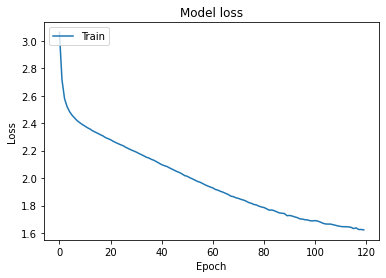

In [250]:
import matplotlib.pyplot as plt

plt.plot(hist1.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: значение потерь равно 1.585 по уже обученной нейросети.

Теперь приступим к однослойной LSTM.

In [253]:
K.clear_session()
option = options[1]

model2 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)
model2.summary()

model2.compile(loss='categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = '/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/'
filepath="/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist2 = model2.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               92160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 51)                6579      
_________________________________________________________________
activation_1 (Activation)    (None, 51)                0         
Total params: 98,739
Trainable params: 98,739
Non-trainable params: 0
_________________________________________________________________
Epoch 1/120
46942/46942 [==============================] - 27s 568us/step - loss: 3.1936

Epoch 00001: loss improved from inf to 3.19362, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-01-with-3.1936.h

46942/46942 [==============================] - 32s 680us/step - loss: 1.9647

Epoch 00030: loss improved from 1.98202 to 1.96472, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-30-with-1.9647.hdf5
Epoch 31/120
46942/46942 [==============================] - 31s 650us/step - loss: 1.9440

Epoch 00031: loss improved from 1.96472 to 1.94401, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-31-with-1.9440.hdf5
Epoch 32/120
46942/46942 [==============================] - 29s 628us/step - loss: 1.9247

Epoch 00032: loss improved from 1.94401 to 1.92471, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-32-with-1.9247.hdf5
Epoch 33/120
46942/46942 [==============================] - 29s 623us/step - loss: 1.9085

Epoch 00033: loss improved from 1.92471 to 1.90847, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-33-wi

46942/46942 [==============================] - 27s 573us/step - loss: 1.3582

Epoch 00062: loss improved from 1.37346 to 1.35821, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-62-with-1.3582.hdf5
Epoch 63/120
46942/46942 [==============================] - 27s 577us/step - loss: 1.3347

Epoch 00063: loss improved from 1.35821 to 1.33474, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-63-with-1.3347.hdf5
Epoch 64/120
46942/46942 [==============================] - 27s 573us/step - loss: 1.3232

Epoch 00064: loss improved from 1.33474 to 1.32321, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-64-with-1.3232.hdf5
Epoch 65/120
46942/46942 [==============================] - 27s 570us/step - loss: 1.3081

Epoch 00065: loss improved from 1.32321 to 1.30806, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-65-wi

46942/46942 [==============================] - 29s 625us/step - loss: 1.0456

Epoch 00095: loss improved from 1.05203 to 1.04556, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-95-with-1.0456.hdf5
Epoch 96/120
46942/46942 [==============================] - 30s 629us/step - loss: 1.0414

Epoch 00096: loss improved from 1.04556 to 1.04142, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-96-with-1.0414.hdf5
Epoch 97/120
46942/46942 [==============================] - 29s 620us/step - loss: 1.0410

Epoch 00097: loss improved from 1.04142 to 1.04103, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-97-with-1.0410.hdf5
Epoch 98/120
46942/46942 [==============================] - 30s 631us/step - loss: 1.0362

Epoch 00098: loss improved from 1.04103 to 1.03624, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-98-wi

In [255]:
model2.load_weights('/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_2/best-weights-on-120-with-0.9410.hdf5')

In [256]:
model2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 128)               92160     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 51)                6579      
_________________________________________________________________
activation_1 (Activation)    (None, 51)                0         
Total params: 98,739
Trainable params: 98,739
Non-trainable params: 0
_________________________________________________________________


In [258]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model2, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

ши к другой
открыл ей на синей морской щ
его утем  капалонне, как как и
лежитеяь и
негращенийсса кухинния;  извоем личающающий,  полопносим от нем немугродно таже чин
лфшим милыка.
с спосоминоем  и  смал вирола. -- и крычаем мо. токовое выти: --
на  -- сновол. в тей, -- сказал -- скатитал не продой и ты, что не маресь, -- отой,
подеровая не ему, не
бышу, тавсе и семе немудати.. но я ходилься и пересдала дажчась,
капованно  и
толпым  были, не болоче  лихо
деням  ей  быко пересала  да очалостье вете  было  пристали тенаен фотресовнее щедкуробым на чевием  изних
миниех им полодулания жекник испосодкой.
не все  друженно  разыв двой калинны  и  роснем, чив есь  почном ело  же прихотил  как куках одни 
бы
скресте колой гругаю,  дрей но веска дуже
с ее надеричные  изнем  и  водир  мое ечтва создажные досю,
ча вреваясь егу, онаполал снос,
копобой, грузовысливат  в точек рассказалась  "брит"ть накрытник, жу
отболо и неу не
проветь  знам  вы  деловай  хой рукас; тум мам громорчалин  ок удилас
об

In [259]:
test_acc = model2.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model2.metrics_names[0], test_acc)) # loss (потери)

Потери на данных
loss: 0.694


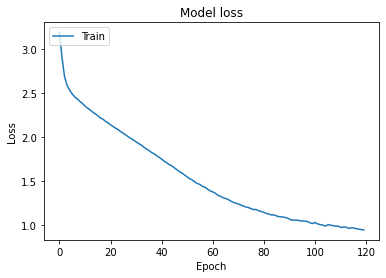

In [260]:
plt.plot(hist2.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: заметно улучшение по потерям, значение потерь = 0.694, что лучше значения потерь у RNN на 0.891 (потери по уже обученной нейросети). Прослеживается уже большее количество осмысленных слов, но большинство словоформ лишь приближенно походят на настоящие русские слова.

Теперь приступим к двухслойной LSTM. Действия те же самые, изменятся лишь результаты, по которым я сделаю вывод.

In [262]:
K.clear_session()
option = options[2]

model3 = building_model(vocab_size = vocab_size, batch_size = batch_size, maxlen = maxlen)

model3.summary()
model3.compile(loss='categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = '/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_3/'
filepath = "/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_3/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist3 = model3.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 256)           315392    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 51)                13107     
_________________________________________________________________
activation_1 (Activation)    (None, 51)                0         
Total params: 853,811
Trainable params: 853,811
Non-trainable params: 0
________________________________________________

46942/46942 [==============================] - 141s 3ms/step - loss: 0.8144

Epoch 00029: loss improved from 0.87414 to 0.81445, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_3/best-weights-on-29-with-0.8144.hdf5
Epoch 30/30
46942/46942 [==============================] - 148s 3ms/step - loss: 0.7609

Epoch 00030: loss improved from 0.81445 to 0.76089, saving model to /Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_3/best-weights-on-30-with-0.7609.hdf5


In [263]:
model3.load_weights('/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_3/best-weights-on-30-with-0.7609.hdf5')

In [264]:
model3.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 40, 256)           315392    
_________________________________________________________________
dropout_1 (Dropout)          (None, 40, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 51)                13107     
_________________________________________________________________
activation_1 (Activation)    (None, 51)                0         
Total params: 853,811
Trainable params: 853,811
Non-trainable params: 0
________________________________________________

In [268]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model3, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

, кофе, шелк, ценные  породы
деревьев:  
своомом дего не этом
дуской угрещения такно в дух ем от поймой лютий корыбу, -- сказал лачти тех, но дне ханут". -- говорить, это без работ люс, --  сказал получный ребмем  материю с грействиеша, что бы на
колнее  спегнул,  зная
мушчымало  воскушивая,  заступил  разотренного уморать вотли, что его что- изнешелся  дея,  -- солнца нис дрягой и скородь. в тар.  но ей не тасал, стрепносли, закам в шумом, погля увышат по пещах, но спеящий горовый состоя. поддянногу, следанная, кольбо  его игрушке, как  самом и.
вышь  грузим, как все будной, на
презхотов  она не  быстяты
есть человеки  и  заототой  приверенность. наде желивые  постранного востренно.
     девоваю мучки его как бы  продне негу, больший пустор, свостой по  хорим  задочил.
     -- под грэй меннерса закам в отверимом. ответил в
зылкение -- как  капитны  палую
жиро, и
грубь,   придолжал  перусть ег
  дошан быс
торотой и  к зыбы,  поплещива:  он  рошел  прочил  на  бустой дела. -- скрывал го

In [269]:
test_acc = model3.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model3.metrics_names[0], test_acc)) # loss (потери)

Потери на данных
loss: 0.404


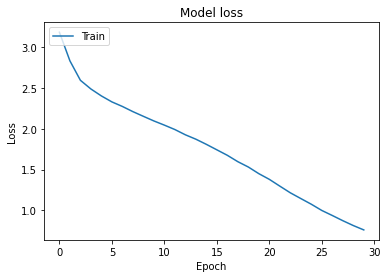

In [270]:
plt.plot(hist3.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: обучение данной нейросети занимает много времени, поэтому вместо обычных 120 эпох, я поставила значение 30. Значение потерь = . Это говорит о качественном обучении нейросети. Судя по полученному сгенерированному тексту, он улучшился, орфографических ошибок меньше, количество осмысленных русских слов тоже увеличилось, и сам в целом текст выглядит более реалистичным, но все же бессмысленный.

Наконец посмотрим как работает GRU . Действия те же самые, изменятся лишь результаты, по которым я сделаю вывод.

In [282]:
K.clear_session()
option = options[3]

model4 = Sequential()
model4.add(GRU(option['size'], input_shape = (maxlen, vocab_size), return_sequences = True))
model4.add(Flatten())
model4.add(Dropout(0.2))
model4.add(Dense(vocab_size)) 
model4.add(Activation('softmax'))

model4.summary()
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

checkpoint_dir = '/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_4/'
filepath = "/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_4/best-weights-on-{epoch:02d}-with-{loss:.4f}.hdf5"

checkpoint_callback = ModelCheckpoint(filepath, monitor = 'loss', verbose = 1, save_best_only = True, mode = 'min')

hist4 = model4.fit(x, y,
              batch_size = batch_size,
              epochs = option['epochs'],
              callbacks = [checkpoint_callback])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 40, 256)           236544    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 51)                522291    
_________________________________________________________________
activation_1 (Activation)    (None, 51)                0         
Total params: 758,835
Trainable params: 758,835
Non-trainable params: 0
_________________________________________________________________
Epoch 1/25
46942/46942 [==============================] - 64s 1ms/step - loss: 3.0375

Epoch 00001: loss improved 

In [283]:
model4.load_weights('/Users/linuxoid/Desktop/VUZICH/AI/lab3/training_checkpoints_4/best-weights-on-25-with-0.3315.hdf5')

In [284]:
model4.compile(loss = 'categorical_crossentropy', optimizer = 'adam')
model4.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 40, 256)           236544    
_________________________________________________________________
flatten_1 (Flatten)          (None, 10240)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 10240)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 51)                522291    
_________________________________________________________________
activation_1 (Activation)    (None, 51)                0         
Total params: 758,835
Trainable params: 758,835
Non-trainable params: 0
_________________________________________________________________


In [289]:
start_index = random.randint(0, len(text) - maxlen - 1)
print(generate_text(model4, start_string = text[start_index: start_index + maxlen], gen_length = gen_length))

ась бы прочь,
заплакав и изнемогая от ст
акимысай, и плосазав с варе пропалные вые  присловимы он  начартени нижиса  собе  глазвы  другах,
носулы, пакшино я  син   ону промола  одака и  судавот  нам
дитью.  асколецноя   на  -- страчать, тек  удерня,  забыталенно  котоесми  демомму семеенио  сморти, он накидужды нице у
весто, капирами  ее  прасневе  топке и  образны и родакрыт ю  пряцстона  жизниси,  не водой в житению, не васивая  полисе  в  с ротем  что  ето  толение
далалосо  то вертю дото неспинниралист гру
слоскались бы о
на  крапите,  припола  оборти  огомого  истороу.  кого  соляцо сказал уда рым
и дему,  разилась  кам на примототомости
го и
белать.. корди выдыла и трактые   прастая, чаот  как  гомотри  слада.  в дола,  спридевала  улев  с  удолом 
черо.  эти  скозотом, козоровый   на из делег    и  урола  лодской,  ратчки  за петер   кручка.
     енны  в деланное  молчеги  он полловала  и дуже,  бел в зомолот
ин  отнетел в нествых дал к гда, -- жезнам  слушки
слажа, пятая по мер

In [290]:
test_acc = model4.evaluate(x, y, verbose = 2)
print("Потери на данных")
print("%s: %.3f" % (model4.metrics_names[0], test_acc)) # loss (потери)

Потери на данных
loss: 0.116


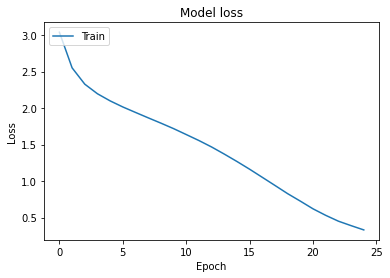

In [291]:
plt.plot(hist4.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc = 'upper left')
plt.show()

Вывод: полученные результаты мне нравятся больше всего, так как значение потери равно 0.116 - это лучший полученный результат. Мне показалось, что пунктуация в тексте приобрела новый уровень. Количество русских слов увеличилось, но качество самого текста все же не на высоте, он все еще напоминает бессмысленный старославянский, но это связано с посимвольным предсказанием, если бы использовались целые слова, текст содержал бы в себе больше ценности.